In [9]:
using Pkg
Pkg.activate("/media/mat/HDD/AdaptiveTransportMap/")

 Activating environment at `/media/mat/HDD/AdaptiveTransportMap/Project.toml`


In [10]:
using Revise
using LinearAlgebra
using BenchmarkTools
using Statistics
using AdaptiveTransportMap
using JLD
using Test
using Plots
using LaTeXStrings

### Simple twin-experiment

In [11]:
# Define parameters
Ne = 100
Nx = 3
Ny = 3
Δtdyn = 0.05
Δtobs = 0.1

σx = 1e-2
σy = 2.0

ϵx = AdditiveInflation(Nx, zeros(Nx), σx)
ϵy = AdditiveInflation(Ny, zeros(Ny), σy)
t0 = 0.0
tf = 600.0
Tf = ceil(Int64, tf/Δtobs)

m0 = zeros(Nx)
C0 = Matrix(1.0*I, Nx, Nx)

f = lorenz63!
h(t,x) = x

model = Model(Nx, Ny, Δtdyn, Δtobs, ϵx, ϵy, m0, C0, 0, 0, 0, f, h);

In [12]:
# Set initial condition
x0 = model.m0 + sqrt(model.C0)*randn(Nx)

# Run dynamics and generate data
data = generate_lorenz63(model, x0, Tf);

In [13]:
# Set initial condition
X = zeros(model.Ny + model.Nx, Ne)
X[model.Ny+1:model.Ny+model.Nx,:] .= sqrt(model.C0)*randn(model.Nx, Ne) .+ model.m0

t0 = 0.0
dyn = DynamicalSystem(model.f, model.h)
enkf = StochEnKF(x->x, model.ϵy, model.Δtdyn, model.Δtobs, false, false)

Stochastic EnKF  with filtered = false


In [14]:
statehist = seqassim(dyn, data, Tf, model.ϵx, enkf, X, model.Ny, model.Nx, t0);

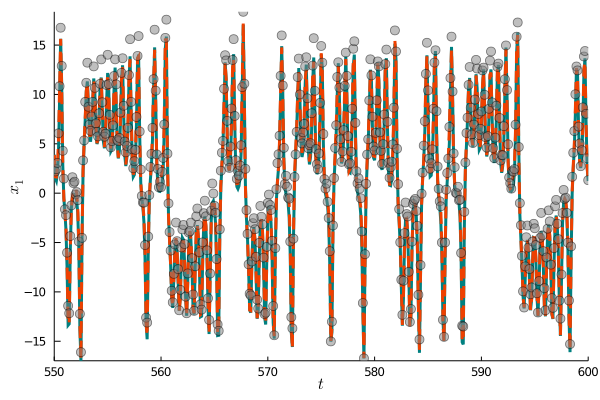

In [15]:
# Plot the first component of the state over time
nb = 5500
ne = 6000
Δ = 1
plt = plot(xlim = (-Inf, Inf), ylim = (-Inf, Inf), xlabel = L"t", ylabel = L"x_1", legend = false)
plot!(plt, data.tt[nb:Δ:ne], data.xt[1,nb:Δ:ne], linewidth =  3, color = :teal)
plot!(plt, data.tt[nb:Δ:ne], mean_hist(statehist)[1,1+nb:Δ:1+ne], linewidth = 3, grid = false,
     color = :orangered2, linestyle = :dash, markersize = 3)
scatter!(plt, data.tt[nb:Δ:ne], data.yt[1,nb:Δ:ne], linewidth = 3, color = :grey, markersize = 5, alpha = 0.5)
plt

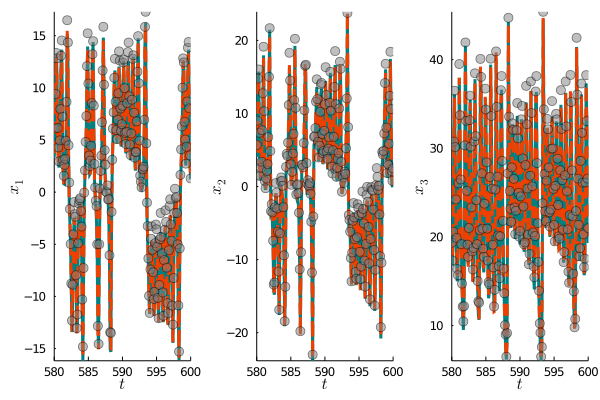

In [16]:
# Plot the different component of the state over time
nb = 5800
ne = 6000
Δ = 1
plt = plot(layout = grid(1,3), xlim = (-Inf, Inf), ylim = (-Inf, Inf), xlabel = L"t", legend = false)

for i =1:3
    plot!(plt[1,i], data.tt[nb:Δ:ne], data.xt[i,nb:Δ:ne], linewidth =  3, color = :teal, ylabel = latexstring("x_"*string(i)))
    plot!(plt[1,i], data.tt[nb:Δ:ne], mean_hist(statehist)[i,1+nb:Δ:1+ne], linewidth = 3, grid = false,
         color = :orangered2, linestyle = :dash, markersize = 3)
    scatter!(plt[1,i], data.tt[nb:Δ:ne], data.yt[i,nb:Δ:ne], linewidth = 3, color = :grey, markersize = 5, alpha = 0.5)
end

plt

### Benchmark of the EnKF filter

In [22]:
path = "/media/mat/HDD/AdaptiveTransportMap/src/lorenz63/data/"
Nx = 3
Ny = 3
Ne_array = [10, 20, 40, 60, 100, 200];
@time model, data = setup_lorenz63(path, Ne_array);

Ne 10 RMSE: 0.5781270551492396
Ne 20 RMSE: 0.5132142964560146
Ne 40 RMSE: 0.46224208018737883
Ne 60 RMSE: 0.4594272662535572
Ne 100 RMSE: 0.4399298312173816
Ne 200 RMSE: 0.45902983338748177
  9.797667 seconds (68.89 M allocations: 6.501 GiB, 8.76% gc time)


In [23]:
metric_list = benchmark_lorenz63(model, data, path, [200], [1.0])

(Ne, β) = (200, 1.0)
  7.739944 seconds (62.75 M allocations: 5.935 GiB, 6.06% gc time)
Ne = 200
Ne 200& β 1.0 RMSE: 0.4189442707516625


1-element Array{Any,1}:
 Metrics[Metrics(200, [0.27418871478089074, 0.4011111920900346, 0.6224367042654201, 1.1940241372680338, 1.178706937442249, 0.629896584355798, 0.37352902606306937, 0.27598562967074297, 0.3415108073527272, 0.5385900049790774  …  0.22005926456584765, 0.11117371050261328, 0.0745833426310767, 0.06915409494524392, 0.23566185689849842, 0.4284533696688461, 0.7382482677445492, 1.2785156926466672, 0.9477650979445261, 0.8579855755647071], 0.2843509443072877, 0.4189442707516625, 0.3843942458358231, [0.2791191166770778, 0.3308824803118106, 0.5356751453956368, 0.7482658949655999, 0.6849666981780923, 0.5401293761758875, 0.3905840265207302, 0.30529026491290673, 0.3612676308031941, 0.5506587576884893  …  0.9550452598208562, 0.7275900415277436, 0.5097020874896808, 0.38068472189933705, 0.44668108906035564, 0.6711198461183089, 0.7934070557338772, 0.953289237580203, 1.0821830718436276, 1.1373384160933897], 0.529889526630428, 0.584733698922179, 0.23401428353181045, [1.0, 1.0, 1.0, 1.